# Model I: GAN Model for asset pricing

Date: 2023/01/27

Model: Orginal GAN model, 

Binary Cross Entropy for loss function, 

criterion = nn.BCELoss()

optimizer = optim.SGD

In [93]:
#%% Import library 
import numpy as np

import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

In [53]:
#%% Pre-defined Function
class GenData(Dataset):
    def __init__(self, features, labels):           # 创建该类时需要输入的数据集
        self.features = features                    # features属性返回数据集特征
        self.labels = labels                        # labels属性返回数据集标签
        self.lens = len(features)                   # lens属性返回数据集大小


    def __getitem__(self, index):
        # 调用该方法时需要输入index数值，方法最终返回index对应的特征和标签
        return self.features[index,:],self.labels[index]    

    def __len__(self):
        # 调用该方法不需要输入额外参数，方法最终返回数据集大小
        return self.lens

#%% Split the data 
# Split the features and labels into training set, validation set and test set.
# We did not shuffle data when slicing the data into three sets
# In each training batch, we use one stock with all time period, batch_size = num_month
def split_loader_valid(features, labels, 
                       train_rate=0.7, 
                       validate_rate=0.2, 
                       test_rate=0.1,
                       batch_size = 20, 
                       shuffle = False):
    """
    In this case, we do not shuffle the data, we keep the data in time-series order
    
    :param batch_size: should be equal to num_month;
    :param train_rate + validate_rate + test_rate =1
    :param shuffle: if shuffle the data in the batch 
    
    :return: (train_loader, test_loader)
    """
    data = GenData(features, labels)
    num_train = (int(num_stock*train_rate))* num_month
    num_validate = (int(num_stock*validate_rate))* num_month
    num_test = num_month * (num_stock -int(num_stock*train_rate) - int(num_stock*validate_rate) )
    data_train, data_validate, data_test = random_split(data,
                                                        [num_train,num_validate,num_test])
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    validate_loader = DataLoader(data_validate, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)
    return (train_loader, validate_loader, test_loader)



In [67]:
#%% Generate Data 
# Assume we have 1000 stocks, 
# and we have 50 variables/features (macro-economic+firm-level characteristics), 
# and we use 50 months monthly return.
num_stock = 250
num_character = 100
num_month = 50
num_input = num_stock * num_month

# Parameters setting
batch_size = 10
split_rate = 0.7

num_epochs = 2
criterion = nn.BCELoss()
optimizer = optim.SGD
lr = 0.03
z_dim = num_character

h_dim_d = 16
h_dim_g = 16

In [68]:
#%% Generate data and split the data
torch.manual_seed(112)
features = torch.rand((num_stock * num_month, num_character), dtype = torch.float32)
labels = torch.rand(size = (num_stock * num_month,1), dtype = torch.float32)
print(features.shape, labels.shape)

train_loader, validate_loader, test_loader = split_loader_valid(
    features, 
    labels, 
    batch_size=num_month
    )
print(next(iter(train_loader))[0].shape) # features - variables
print(next(iter(train_loader))[1].shape) # label - return at next period

torch.Size([12500, 100]) torch.Size([12500, 1])
torch.Size([50, 100])
torch.Size([50, 1])


In [70]:
# 70% training set => 1000 * 0.7 = 700 stocks 
#for batch_idx, (x,y) in enumerate(train_loader):
#    print(batch_idx+1,(x.shape,y.shape))

## II. Define GAN Model

(1) Generator:
`gen = Generator(in_features = num_character, out_features=1)#.to(device)`

(2) Discriminator:
`disc = Discriminator(in_features = num_month)#.to(device)`

In [71]:
#%% Model I: GAN Model
# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(nn.Linear(in_features, h_dim_d),
                                  #nn.BatchNorm1d(h_dim), 
                                  nn.ReLU(True), 
                                  nn.Linear(h_dim_d, h_dim_d), 
                                  nn.ReLU(True), 
                                  nn.Linear(h_dim_d, h_dim_d), 
                                  nn.ReLU(True),
                                  nn.Linear(h_dim_d,1),
                                  nn.Sigmoid(), # output probability (1: real data/ 0:fake data)
                                  )
    def forward(self, data):
        output = self.disc(data)
        return output

# Define Generator 
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        '''
        in_features: dimension of noise z 
        out_features: has the same dimension of the real data 
        
        z [b, num_character]
        '''
        super().__init__()
        self.gen = nn.Sequential(nn.Linear(in_features, h_dim_g),
                                 # nn.BatchNorm1d(h_dim_g),
                                 nn.ReLU(True),
                                 nn.Linear(h_dim_g, h_dim_g), 
                                 nn.ReLU(True), 
                                 nn.Linear(h_dim_g, h_dim_g), 
                                 nn.ReLU(True), 
                                 nn.Linear(h_dim_g, out_features), 
                                 nn.Tanh(),)
                                 
    def forward(self, z):
        gz = self.gen(z)
        return gz

In [73]:
# Trial GAN structure -- Generator
z = torch.ones((50,100))
real = torch.randn((50,1))
gen = Generator(in_features=100, out_features=1)
gen_out = gen(z)
print(f'Shape of output from generator: {gen_out.shape}')
gen_out_reshape = gen_out.view(-1)
print(f'After reshape: {gen_out_reshape.shape}')

Shape of output from generator: torch.Size([50, 1])
After reshape: torch.Size([50])


In [35]:
# Trial GAN structure -- Discriminator
disc = Discriminator(50)
disc_out = disc(gen_out_reshape)
print(disc_out, disc_out.shape)

tensor([0.5187], grad_fn=<SigmoidBackward0>) torch.Size([1])


In [31]:
disc_real = disc(real.view(-1))
print(disc_real)

tensor([0.5254], grad_fn=<SigmoidBackward0>)


In [75]:
G_losses = []
D_real_loss = []
D_fake_loss = []
D_losses = []

In [76]:
# Define Main Function
def main_gan():
    torch.manual_seed(112)
    np.random.seed(112)
    #device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
    
    # fixed noise, differenciate the updated noise input the z
    fixed_noise = torch.randn((num_input, z_dim))#.to(device)

    gen = Generator(in_features = num_character, out_features=1)#.to(device)
    disc = Discriminator(in_features = num_month)#.to(device)
    
    optim_disc = optim.Adam(disc.parameters(), lr=lr, betas = (0.9,0.0999))
    optim_gen = optim.Adam(gen.parameters(), lr=lr, betas = (0.9,0.0999))
    criterion = nn.BCELoss(reduction = 'mean')
    
    for epoch in range(num_epochs):
        for batch_idx, (noise,real) in enumerate(train_loader):
            # noise_size =(20,100), real_size=(20,1)
            
            ##############################################
            ##### Discriminator Backward Propagation #####
            ###  Minimize -[logD(x) + log(1-D(G(z))]   ###
            ##############################################
            # -logdx
            real = real.view(-1)
            dx = disc(real).view(-1)
            loss_real = criterion(dx, torch.ones_like(dx))
            loss_real.backward()
            D_x = dx.mean().item()
            
            # -log(1-dgz) 
            # noise here is the variables from stock-level characteristics 
            # noise=torch.randn((batch_size,z_dim)).to(device)
            gz = gen(noise).view(-1)
            dgz1 = disc(gz.detach())
            loss_fake = criterion(dgz1, torch.zeros_like(dgz1))
            loss_fake.backward()
            D_G_z1 = dgz1.mean().item()
            
            # calculate error D
            errorD = (loss_real + loss_fake) / 2
            optim_disc.step() # update the weights of the Disctriminator 
            disc.zero_grad()
            
            ##############################################
            ####### Generator Backward Propagation #######
            ######### Minimize -log[D(g(z))] #############
            ##############################################
            dgz2 = disc(gz)
            errorG = criterion(dgz2, torch.ones_like(dgz2))
            errorG.backward()
            optim_gen.step() # update the weights on the Discriminator 
            gen.zero_grad()
            D_G_z2 = dgz2.mean().item()
            
            ## Minitor the training process 
            G_losses.append(errorG.item())
            D_real_loss.append(loss_real.item())
            D_fake_loss.append(loss_fake.item())
            D_losses.append(errorD.item())
            
            print(f'[{epoch+1}/{num_epochs}], [{batch_idx}/{len(train_loader)}]')
            print(f'Loss_D:{errorD.item()}, Loss_G:{errorG.item()}' )
            print(f'D(x):{D_x}, D(G(z)):{D_G_z1}/{D_G_z2} \n')

In [77]:
main_gan()

[1/2], [0/175]
Loss_D:0.6945123672485352, Loss_G:0.735095202922821
D(x):0.5001128315925598, D(G(z)):0.5014758110046387/0.47945982217788696 

[1/2], [1/175]
Loss_D:0.6951418519020081, Loss_G:0.6871373653411865
D(x):0.4873565435409546, D(G(z)):0.489070862531662/0.5030139684677124 

[1/2], [2/175]
Loss_D:0.6907670497894287, Loss_G:0.6715107560157776
D(x):0.5033473968505859, D(G(z)):0.5009552240371704/0.5109360814094543 

[1/2], [3/175]
Loss_D:0.6913703680038452, Loss_G:0.6487279534339905
D(x):0.5126846432685852, D(G(z)):0.5106348991394043/0.5227102637290955 

[1/2], [4/175]
Loss_D:0.6904696226119995, Loss_G:0.553849458694458
D(x):0.5266015529632568, D(G(z)):0.5227086544036865/0.5747331380844116 

[1/2], [5/175]
Loss_D:0.7199786901473999, Loss_G:0.13145875930786133
D(x):0.5571510195732117, D(G(z)):0.5747331380844116/0.8768154382705688 

[1/2], [6/175]
Loss_D:1.18901526927948, Loss_G:0.03544284775853157
D(x):0.7527976036071777, D(G(z)):0.8768154382705688/0.9651778936386108 

[1/2], [7/175]


[1/2], [146/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [147/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [148/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [149/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [150/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [151/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [152/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [153/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [154/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [155/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [156/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [157/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [158/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2], [159/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[1/2],

[2/2], [125/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [126/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [127/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [128/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [129/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [130/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [131/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [132/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [133/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [134/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [135/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [136/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [137/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2], [138/175]
Loss_D:50.0, Loss_G:100.0
D(x):0.0, D(G(z)):0.0/0.0 

[2/2],

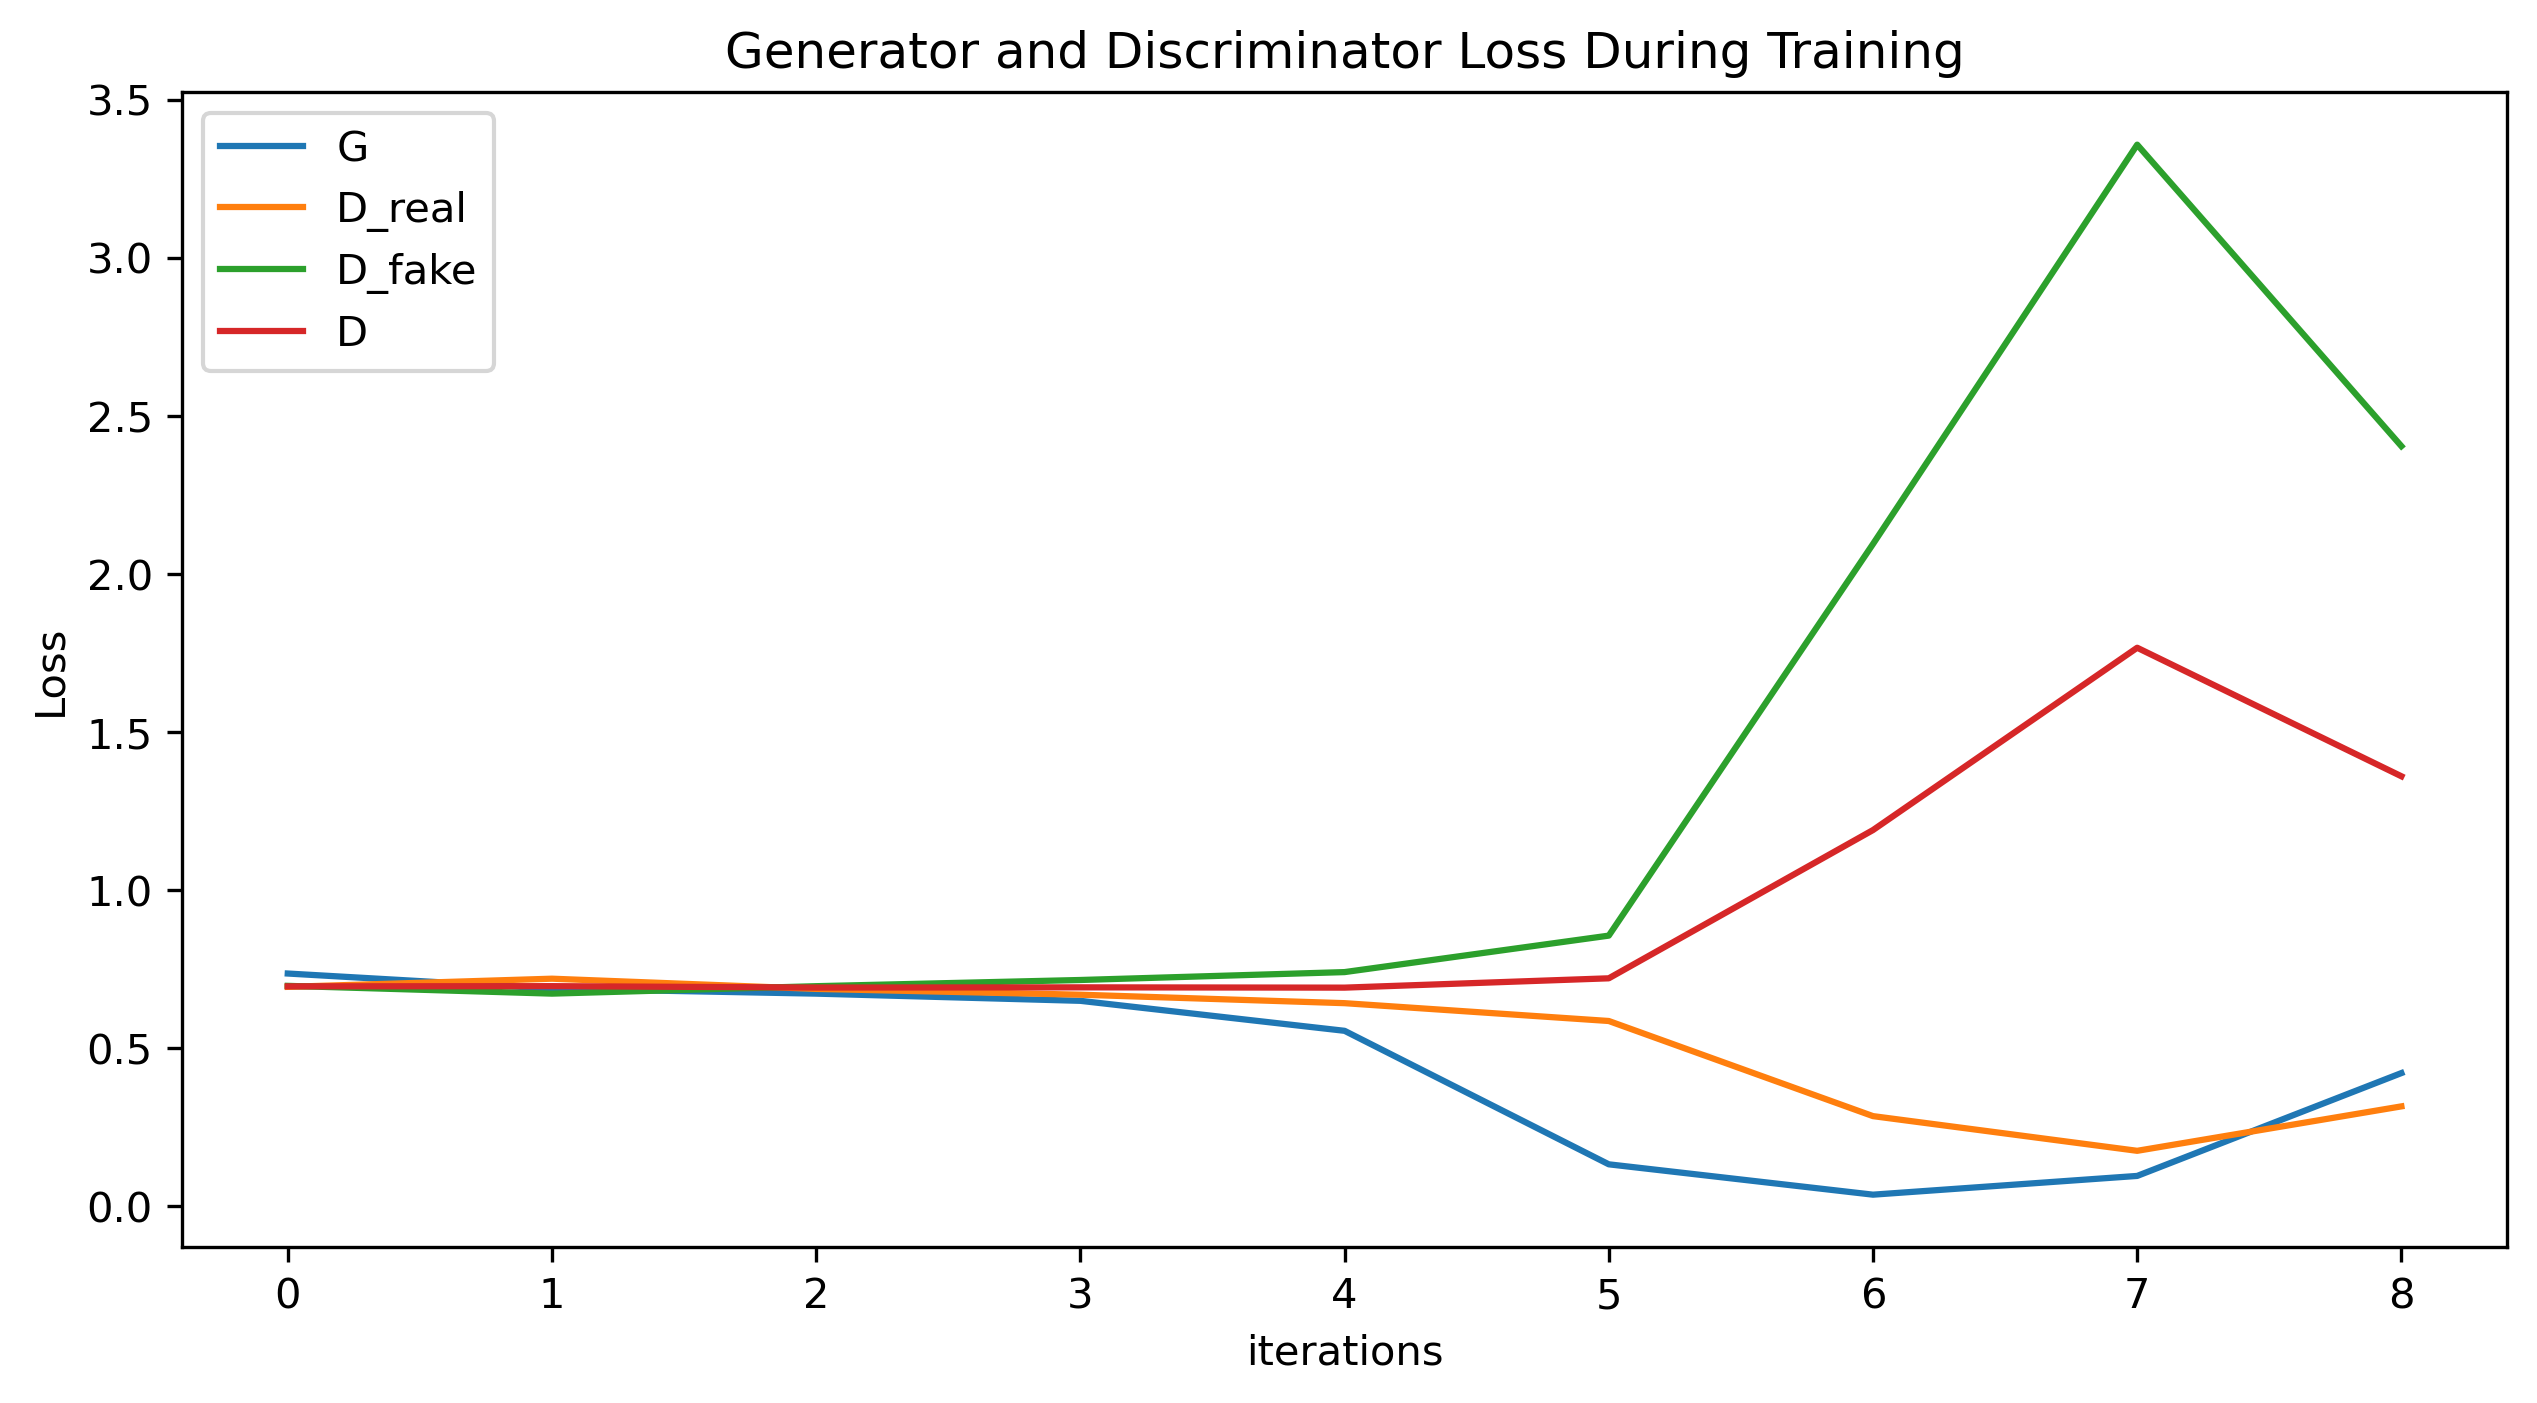

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5),dpi=300)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[:9],label="G")
plt.plot(D_real_loss[:9],label="D_real")
plt.plot(D_fake_loss[:9],label="D_fake")
plt.plot(D_losses[:9],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

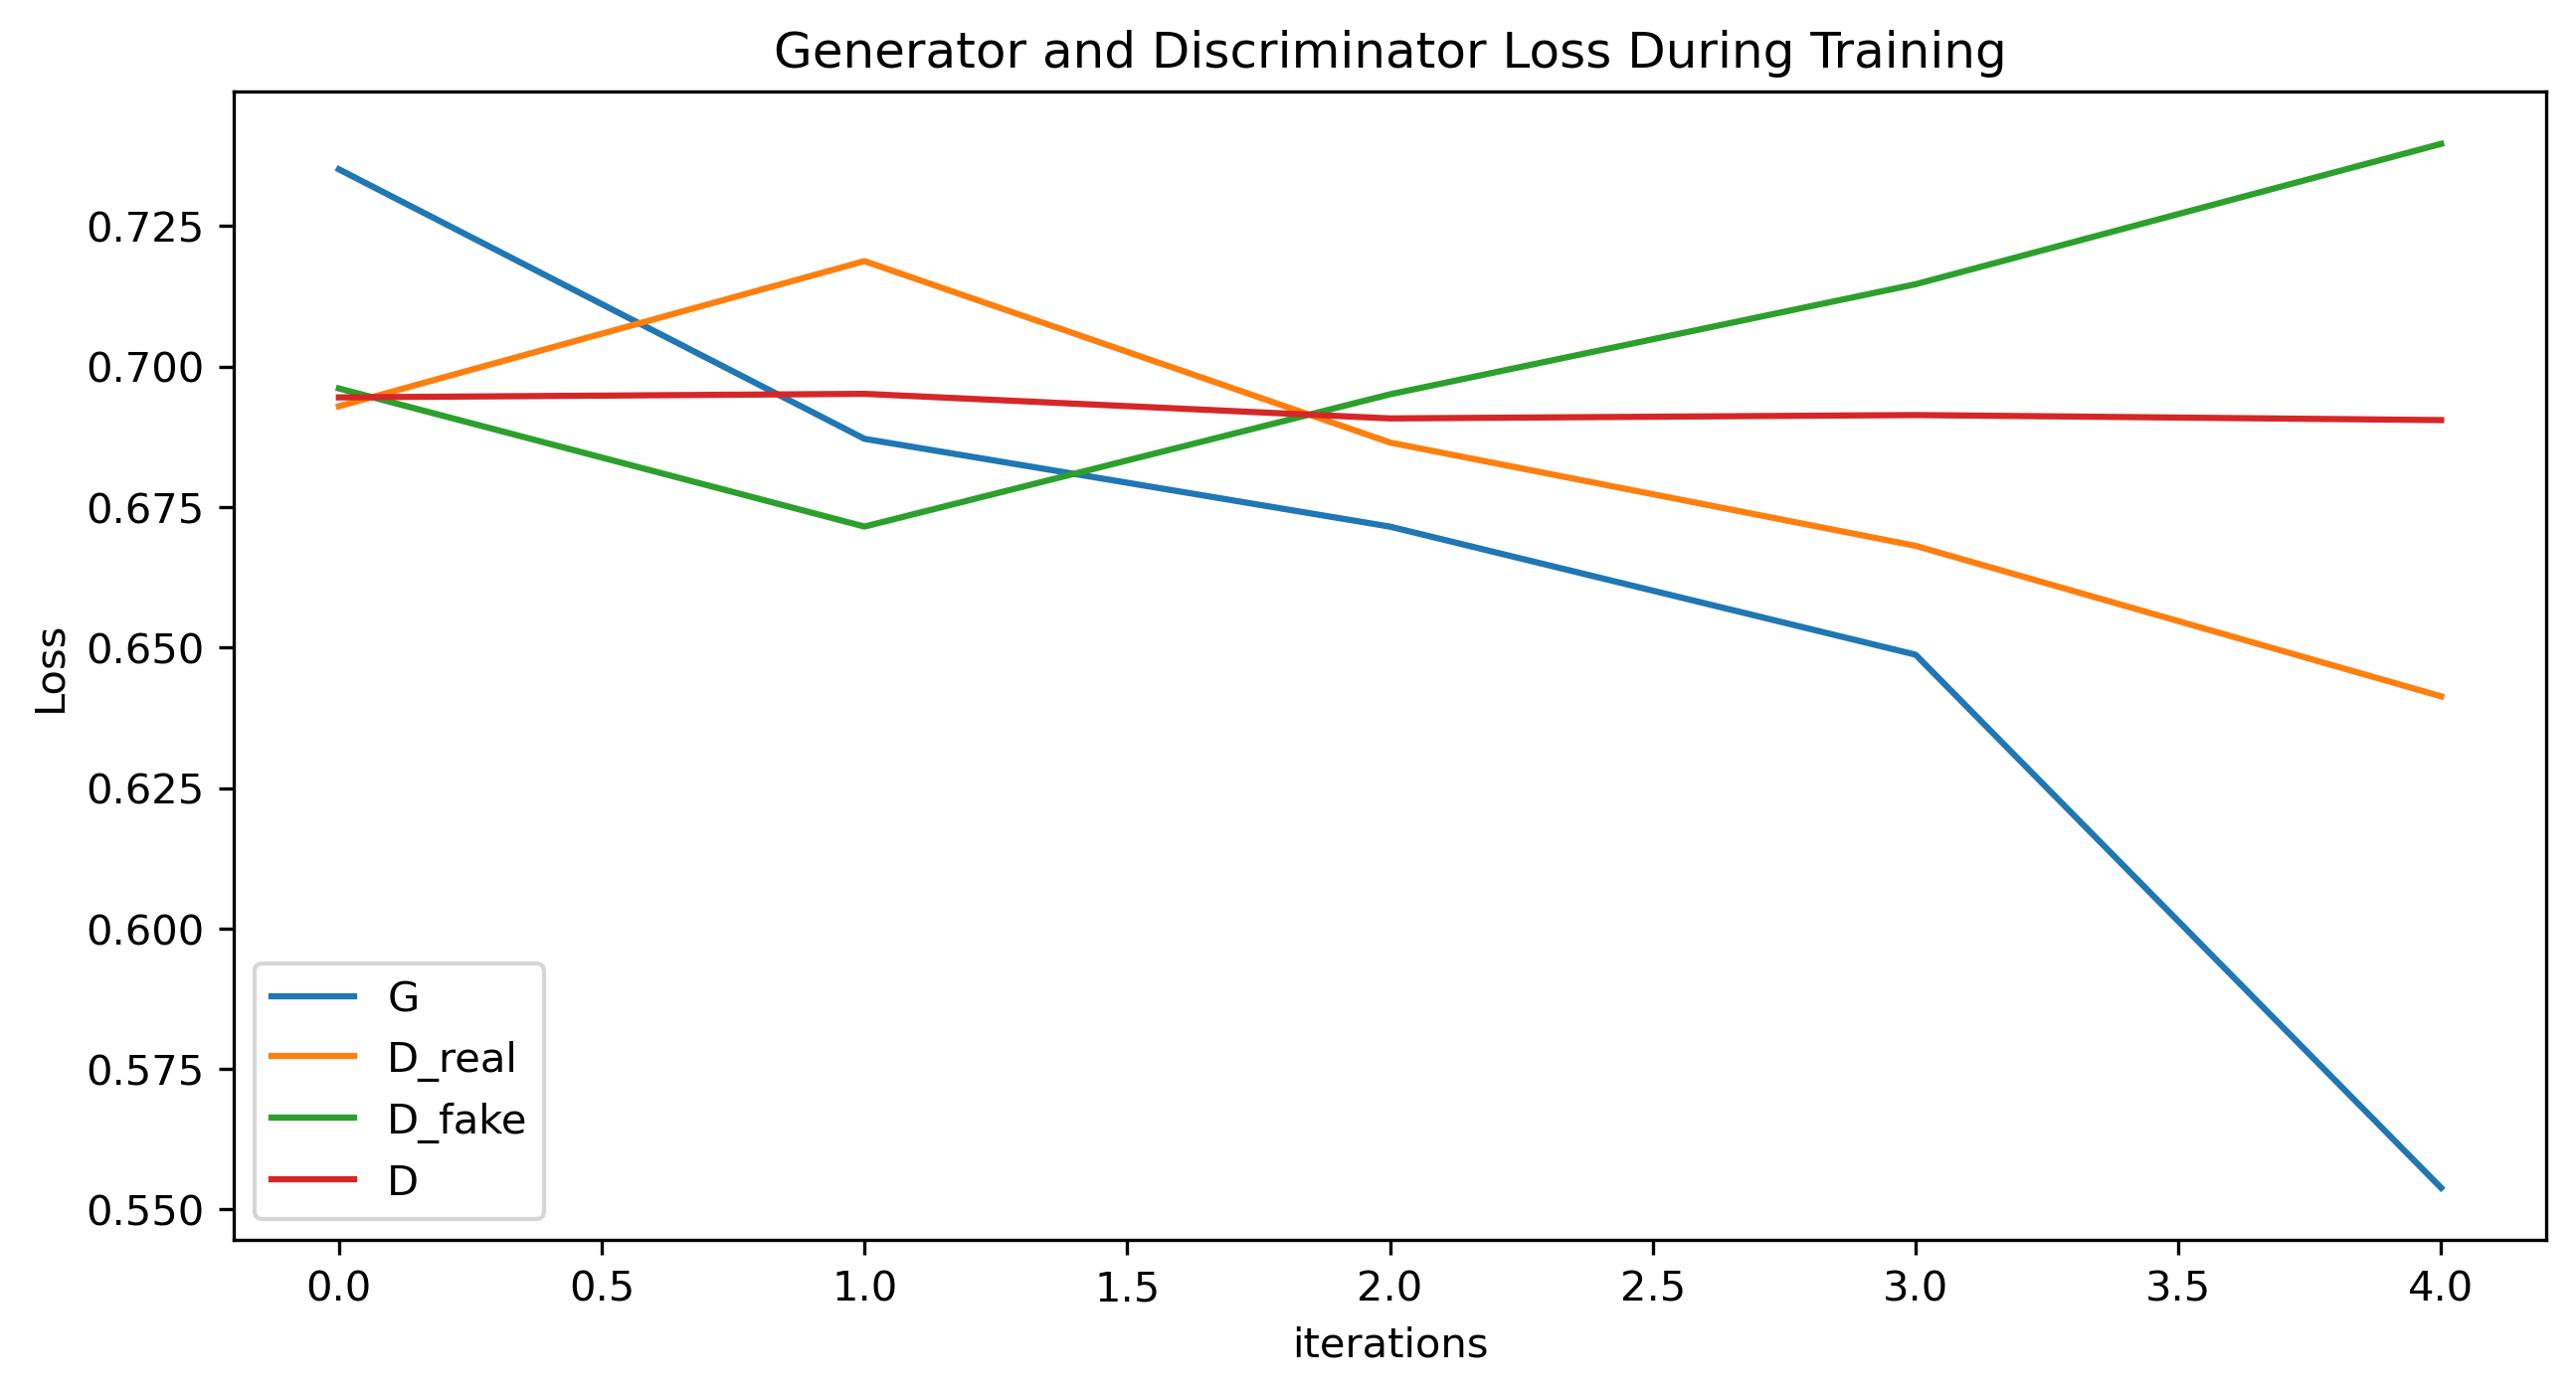

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5),dpi=300)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[:5],label="G")
plt.plot(D_real_loss[:5],label="D_real")
plt.plot(D_fake_loss[:5],label="D_fake")
plt.plot(D_losses[:5],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [87]:
# Trial GAN structure -- Generator
noise = torch.randn((50,100))
real = torch.randn((50,1)).view(-1)

gen = Generator(in_features=100,out_features=1)
disc = Discriminator(in_features=50)

gen_out = gen(z)
print(f'Shape of output from generator: {gen_out.shape}')

Shape of output from generator: torch.Size([50, 1])


In [92]:
dx_real = disc(real).view(-1)
print(dx)
dx_fake = disc(gen(z).view(-1))
print(dx_fake)
loss_real = criterion(dx_real,torch.ones_like(dx))
loss_real.backward()
D_x = dx.mean().item()


tensor([0.5672], grad_fn=<ViewBackward0>)
tensor([0.5683], grad_fn=<SigmoidBackward0>)
